### Importing Libraries

In [2]:
#! pip install --upgrade scikit-learn
#! pip install imbalanced-learn scikit-learn

In [3]:
import os
import nltk
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
import seaborn as sns
from gensim.models import KeyedVectors
from psutil import virtual_memory
from lxml import etree
from sklearn.pipeline import Pipeline
from IPython.display import display
import time

### Importing data

In [4]:
#os.chdir(r"C:\Users\Lillian Hurban\Downloads\STOR 565\final project")
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
%cd /content/gdrive/MyDrive/STOR565_Final/datasets

raw_text = pd.read_csv("raw_data_TDAVIDSON.csv")

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1Tbp026zpLd5YjyO_75pt7ugK-jDwYGE_/STOR565_Final/datasets


### Cleaning tweets

In [5]:
nltk.download('stopwords')

def clean_tweet(tweet):
    tweet = tweet.lower() #Lowercase
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) # Remove URLs
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^\w\s\']', '', tweet)  # Remove special characters except apostrophes
    tweet = re.sub(r'\s+', ' ', tweet).strip()     # Remove extra whitespace
    tweet = re.sub(r'rt', ' ', tweet).strip() # Remove "rt"
    tweet = re.sub(r'@[^\s]+', '', tweet)  # Remove user handles
    tweet_tokens = tweet.split()  # Split tweet into words
    tweet = ' '.join([word for word in tweet_tokens if word not in stopwords.words('english')])
    return tweet

if 'tweet' in raw_text.columns:
    raw_text['clean_tweet'] = raw_text['tweet'].apply(clean_tweet)
    raw_text = raw_text.rename(columns={'tweet': 'og_tweet'})

raw_text['tweet_length'] = raw_text['clean_tweet'].apply(len)

raw_text["class"] = raw_text["class"].apply(lambda x: 1 if x in [0, 1] else 0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
average_char_count = raw_text['clean_tweet'].apply(len).mean()
print(f"Average character count per tweet: {average_char_count}")


Average character count per tweet: 53.3208651091474


### MAKE SURE IT WORKED

<Axes: xlabel='class'>

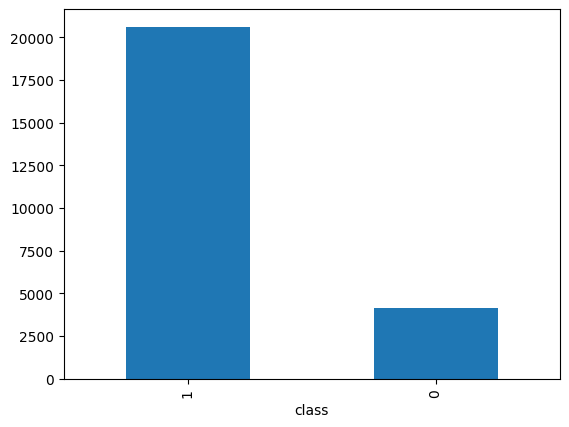

In [7]:
class_labels = raw_text["class"]
class_counts = class_labels.value_counts()
class_counts.plot.bar()

### Training/testing split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(raw_text["clean_tweet"],
                                                    raw_text["class"],
                                                    test_size = 0.3,
                                                    random_state = 42)


In [9]:
# Convert data frame to list
tweet_data = raw_text['clean_tweet'].tolist()

# Tokenize the text data
tweet_tokens = [tweet.split() for tweet in tweet_data]

Tf-IDF and Bag of Words Vectorizers

In [10]:
tfidf = TfidfVectorizer()
bow = CountVectorizer()

#Tf-IDF Test Train
tfidf_xtrain = tfidf.fit_transform(x_train)
tfidf_xtest = tfidf.transform(x_test)

#Bag of Words (bow) Test Train
bow_xtrain = bow.fit_transform(x_train)
bow_xtest = bow.fit(x_test)

**Word2Vec**

Note: Word2Vec does not have a built in .fit_transform function like tf-idf and Bag of Words, so I am creating a helper function

RESULT: Tried Word2Vec, but too computationally expensive, took way too long to run, setting 26366 features is just not worth it. Commented the code out just for reference.

In [11]:
def convert_glove_to_word2vec(glove_input_file, word2vec_output_file):
    # Count the number of lines (words) in the GloVe file
    num_lines = sum(1 for line in open(glove_input_file, 'r', encoding='utf-8'))

    # Read the dimensions from the first line
    with open(glove_input_file, 'r', encoding='utf-8') as f:
        dimensions = len(f.readline().split()) - 1

    # Write the header and the GloVe vectors to the new word2vec file
    with open(word2vec_output_file, 'w', encoding='utf-8') as outfile:
        outfile.write(f"{num_lines} {dimensions}\n")
        with open(glove_input_file, 'r', encoding='utf-8') as infile:
            for line in infile:
                outfile.write(line)

# Path to the GloVe file
glove_input_file = 'glove.twitter.27B.50d.txt'
word2vec_output_file = 'glove.twitter.27B.50d.w2vformat.txt'

# Convert the file
convert_glove_to_word2vec(glove_input_file, word2vec_output_file)

In [12]:
# 4. Split the cleaned description into word tokens
corpus = []
for row in raw_text['clean_tweet']:
    corpus.append(row.split())

In [13]:
# Load the converted GloVe model in word2vec format
word2vec_model = KeyedVectors.load_word2vec_format('glove.twitter.27B.50d.w2vformat.txt', binary=False)

# Load pre-trained GloVe model
pretrained_vectors = KeyedVectors.load_word2vec_format('glove.twitter.27B.50d.w2vformat.txt', binary=False)

# Initialize Word2Vec with the loaded vectors
word2vec_model = Word2Vec(vector_size=50, min_count=1)  # ensure the size matches GloVe dimension
word2vec_model.build_vocab([list(pretrained_vectors.key_to_index.keys())])
word2vec_model.wv.vectors[:] = pretrained_vectors.vectors

# Lock the vectors to prevent them from being updated during training
word2vec_model.wv.vectors_lockf = np.zeros(len(word2vec_model.wv.vectors), dtype=np.float32)

# Build vocabulary from your corpus (assuming 'corpus' is a list of tokenized texts)
word2vec_model.build_vocab(corpus, update=True)

# Fine-tune the model on your corpus
word2vec_model.train(corpus, total_examples=len(corpus), epochs=5)

(927709, 1035975)

In [14]:
def tweet_to_vector(tweet, model):
    """Converts a tweet to a vector by averaging the Word2Vec vectors of its words."""
    words = tweet.split()  # Tokenize the tweet; ensure your preprocessing matches the training phase of Word2Vec
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if not word_vectors:
        return np.zeros(model.vector_size)  # Return a zero vector if tweet contains no known words

    return np.mean(word_vectors, axis=0)


x_train_vectors = np.array([tweet_to_vector(tweet, word2vec_model) for tweet in x_train])
x_test_vectors = np.array([tweet_to_vector(tweet, word2vec_model) for tweet in x_test])

In [15]:
'''# Assume you have already converted your DataFrame to a list and tokenized it as shown:
tweet_data = raw_text['clean_tweet'].tolist()
tweet_tokens = [tweet.split() for tweet in tweet_data]

# Train the Word2Vec model on the tokenized tweets
word2vec = Word2Vec(tweet_tokens, vector_size=26366, window=5, min_count=1, seed=42)

# Save the trained Word2Vec model
word2vec.save("word2vec_model.bin")

# Function to create a document vector by averaging word vectors
def document_vector(word2vec_model, doc):
    # Filter out words that are not in the model's vocabulary
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    # If no words in the model's vocabulary, return a zero vector
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Otherwise, compute the mean of the word vectors for the document
    return np.mean(word2vec_model.wv[doc], axis=0)

# Convert train and test sets to list of tokenized tweets for vectorization
x_train_tokens = [tweet.split() for tweet in x_train]
x_test_tokens = [tweet.split() for tweet in x_test]

# Create document vectors for training and testing datasets
word2vec_xtrain = np.array([document_vector(word2vec, tweet) for tweet in x_train_tokens])
word2vec_xtest = np.array([document_vector(word2vec, tweet) for tweet in x_test_tokens])'''

'# Assume you have already converted your DataFrame to a list and tokenized it as shown:\ntweet_data = raw_text[\'clean_tweet\'].tolist()\ntweet_tokens = [tweet.split() for tweet in tweet_data]\n\n# Train the Word2Vec model on the tokenized tweets\nword2vec = Word2Vec(tweet_tokens, vector_size=26366, window=5, min_count=1, seed=42)\n\n# Save the trained Word2Vec model\nword2vec.save("word2vec_model.bin")\n\n# Function to create a document vector by averaging word vectors\ndef document_vector(word2vec_model, doc):\n    # Filter out words that are not in the model\'s vocabulary\n    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]\n    # If no words in the model\'s vocabulary, return a zero vector\n    if len(doc) == 0:\n        return np.zeros(word2vec_model.vector_size)\n    # Otherwise, compute the mean of the word vectors for the document\n    return np.mean(word2vec_model.wv[doc], axis=0)\n\n# Convert train and test sets to list of tokenized tweets for vectoriz

In [16]:
'''#Try combining TF-IDF and Word2Vec

# Convert sparse TFIDF vectors to dense form if they are not already
tfidf_xtrain_dense = tfidf_xtrain.toarray()
tfidf_xtest_dense = tfidf_xtest.toarray()

# Concatenate Word2Vec features with TFIDF features
combined_xtrain = np.hstack([tfidf_xtrain_dense, word2vec_xtrain])
combined_xtest = np.hstack([tfidf_xtest_dense, word2vec_xtest])'''

'#Try combining TF-IDF and Word2Vec\n\n# Convert sparse TFIDF vectors to dense form if they are not already\ntfidf_xtrain_dense = tfidf_xtrain.toarray()\ntfidf_xtest_dense = tfidf_xtest.toarray()\n\n# Concatenate Word2Vec features with TFIDF features\ncombined_xtrain = np.hstack([tfidf_xtrain_dense, word2vec_xtrain])\ncombined_xtest = np.hstack([tfidf_xtest_dense, word2vec_xtest])'

### SMOTE
Could try SMOTE resampling for unbalanced data.

In [17]:
# Initialize the SMOTE sampler
smote = SMOTE(random_state=42)

# Resample the training data
tfidf_xtrain_res, tfidf_ytrain_res = smote.fit_resample(tfidf_xtrain, y_train)

### Grid searching

In [18]:
param_grid_SVM =  {"C": [0.01, 0.1, 1, 2, 5, 10, 100]}
param_grid_NB = {"alpha": [0.01, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 10]}
param_grid_KNN = {"n_neighbors": [1, 5, 7, 10, 15, 20, 25],
                  "p": [1, 2]}

support_vector_machine = LinearSVC(max_iter = 5000, dual = False)
naive_bayes = MultinomialNB()
k_nearest_neighbor = KNeighborsClassifier()

gridsearch_svm = GridSearchCV(support_vector_machine, param_grid_SVM, cv = 10)
gridsearch_nb = GridSearchCV(naive_bayes, param_grid_NB, cv = 10)
#gridsearch_knn = GridSearchCV(k_nearest_neighbor, param_grid_KNN, cv = 10)

best_svm = gridsearch_svm.fit(tfidf_xtrain, y_train)
best_nb = gridsearch_nb.fit(tfidf_xtrain, y_train)
#best_knn = gridsearch_knn.fit(tfidf_xtrain, y_train)

print("Best parameters for SVM: ", best_svm.best_params_)
print("Best parameters for Naive Bayes: ", best_nb.best_params_)
#print("Best parameters for K-Nearest Neighbors: ", best_knn.best_params_)

Best parameters for SVM:  {'C': 1}
Best parameters for Naive Bayes:  {'alpha': 0.1}


### Evaluating Predictions

2.1.1: **TF-IDF Vectorizer**: Predictions of SVM, Naive Bayes, KNN, and Logistic Regression

In [19]:
#Predictions using tf-idf vectorizer
svm = LinearSVC(dual = False, C = 1)
svm_word2vec = LinearSVC(dual = False, C = 1)
nb = MultinomialNB(alpha = 0.1)
knn = KNeighborsClassifier(n_neighbors = 10, p = 2)
lr = LogisticRegression(max_iter=1000)
lr_SMOTE = LogisticRegression(max_iter=1000)

svm_ideal = svm.fit(tfidf_xtrain, y_train)
svm_word_ideal = svm.fit(x_train_vectors, y_train)
nb_ideal = nb.fit(tfidf_xtrain, y_train)
knn_ideal = knn.fit(tfidf_xtrain, y_train)
lr_ideal = lr.fit(tfidf_xtrain, y_train)
lr_SMOTE_ideal = lr_SMOTE.fit(tfidf_xtrain_res, tfidf_ytrain_res)

svm_pred = svm_ideal.predict(tfidf_xtest)
svm_word_pred = svm_word_ideal.predict(x_test_vectors)
nb_pred = nb_ideal.predict(tfidf_xtest)
knn_pred = knn_ideal.predict(tfidf_xtest)
lr_pred = lr_ideal.predict(tfidf_xtest)
lr_SMOTE_pred = lr_SMOTE_ideal.predict(tfidf_xtest)

confusion_svm = confusion_matrix(y_test, svm_pred, labels = svm_ideal.classes_)
confusion_svm_word = confusion_matrix(y_test, svm_word_pred, labels = svm_word_ideal.classes_)
confusion_nb = confusion_matrix(y_test, nb_pred, labels = nb_ideal.classes_)
confusion_knn = confusion_matrix(y_test, knn_pred, labels = knn_ideal.classes_)
confusion_lr = confusion_matrix(y_test, lr_pred, labels=lr_ideal.classes_)
confusion_lr_SMOTE = confusion_matrix(y_test, lr_pred, labels=lr_SMOTE_ideal.classes_)

total_samples = np.sum(confusion_svm) # all three of these methods should have the same diagonal amount so only one total is necessary

consvm = confusion_svm / total_samples
consvmword = confusion_svm_word / total_samples
connb = confusion_nb / total_samples
conknn = confusion_knn / total_samples
conlr = confusion_lr / total_samples
conlrSM = confusion_lr_SMOTE / total_samples

ValueError: X has 26275 features, but LinearSVC is expecting 50 features as input.

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
#Helper function to print metrics
def print_model_metrics(model_name, predictions, y_test):

    # Calculate metrics
    report = classification_report(y_test, predictions, output_dict=True)
    confusion = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    total_samples = np.sum(confusion)
    normalized_confusion = confusion / total_samples

    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

    # Styling
    styled_df = report_df.style.set_properties(**{'background-color': 'lightblue',
                                                 'color': 'black',
                                                 'border-color': 'black',
                                                 'border-style': 'solid',
                                                 'border-width': '1px'})

    def highlight_metrics(row):
      if row.name == '1':
          return ['background-color: yellow']*len(row)
      else:
          return ['background-color: lightblue']*len(row)

    styled_df = styled_df.apply(highlight_metrics, axis=1)

    styled_df.set_table_styles([{'selector': 'th',
                                 'props': [('background-color', '#4f6379'),
                                           ('color', 'white'),
                                           ('border-color', 'black'),
                                           ('border-style', 'solid'),
                                           ('border-width', '1px')]}])

    styled_df.set_caption(f"<b>{model_name}</b>")

    display(styled_df)

# Example usage
print_model_metrics("SVM", svm_pred, y_test)
print_model_metrics("Naive Bayes", nb_pred, y_test)
print_model_metrics("KNN", knn_pred, y_test)
print_model_metrics("Logistic Regression", lr_pred, y_test)
print_model_metrics("Logistic Regression with SMOTE", lr_SMOTE_pred, y_test)

,precision,recall,f1-score,support
0,0.8421,0.8374,0.8398,1261.0000
1,0.9668,0.9679,0.9674,6174.0000
accuracy,0.9458,0.9458,0.9458,0.9458
macro avg,0.9045,0.9027,0.9036,7435.0000
weighted avg,0.9457,0.9458,0.9457,7435.0000


,precision,recall,f1-score,support
0,0.8516,0.4005,0.5448,1261.0000
1,0.8895,0.9857,0.9352,6174.0000
accuracy,0.8865,0.8865,0.8865,0.8865
macro avg,0.8706,0.6931,0.7400,7435.0000
weighted avg,0.8831,0.8865,0.8689,7435.0000


,precision,recall,f1-score,support
0,0.8245,0.3204,0.4615,1261.0000
1,0.8766,0.9861,0.9281,6174.0000
accuracy,0.8732,0.8732,0.8732,0.8732
macro avg,0.8505,0.6532,0.6948,7435.0000
weighted avg,0.8678,0.8732,0.8490,7435.0000


,precision,recall,f1-score,support
0,0.8733,0.6725,0.7599,1261.0000
1,0.9361,0.9801,0.9576,6174.0000
accuracy,0.9279,0.9279,0.9279,0.9279
macro avg,0.9047,0.8263,0.8587,7435.0000
weighted avg,0.9255,0.9279,0.9241,7435.0000


,precision,recall,f1-score,support
0,0.7629,0.9389,0.8418,1261.0000
1,0.9869,0.9404,0.9631,6174.0000
accuracy,0.9401,0.9401,0.9401,0.9401
macro avg,0.8749,0.9397,0.9024,7435.0000
weighted avg,0.9489,0.9401,0.9425,7435.0000


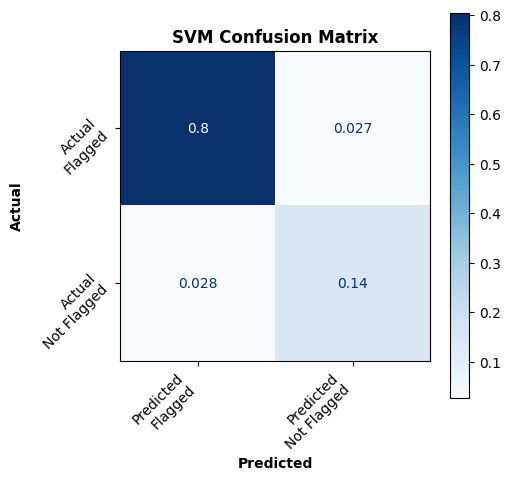

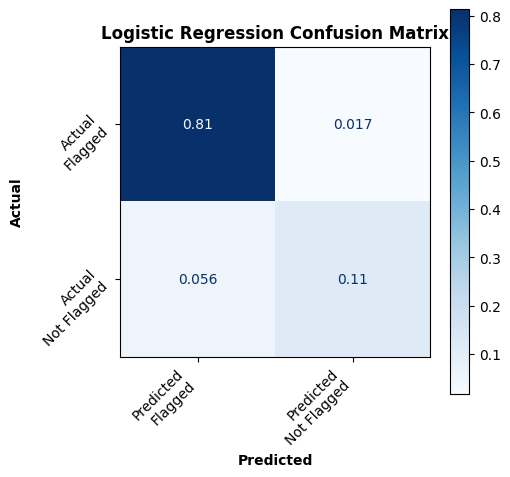

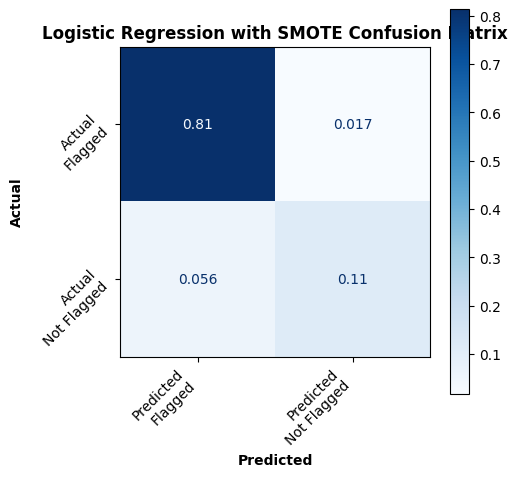

In [ ]:
#Helper function to print confusion matrix
def print_confusion_matrix(conf_matrix, model_name):

    # Invert the confusion matrix order
    conf_matrix_inverted = conf_matrix[::-1, ::-1]

    # Create a matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix_inverted, display_labels=['Not Flagged', 'Flagged']).plot(cmap="Blues", ax=ax)

    # Set labels and tick labels
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xticklabels(['Predicted\nFlagged', 'Predicted\nNot Flagged'], rotation=45, ha="right")
    ax.set_yticklabels(['Actual\nFlagged', 'Actual\nNot Flagged'], rotation=45, ha="right")
    ax.set_title(f"{model_name} Confusion Matrix", fontweight='bold')

#Example usage
print_confusion_matrix(consvm, "SVM")
print_confusion_matrix(conlr, "Logistic Regression")
print_confusion_matrix(conlrSM, "Logistic Regression with SMOTE")

Issue: Cannot use Word2Vec vectorizer by itself since you must set a fixed amount of word_vectors, while tf_idf and bag of words fit to the data. E.g. you can't set word_vectors = 300 when the number of features is actually 26366 features as input

Solution: Combine TF-IDF and Word2Vec

2.1.2 **TF-IDF & Word2Vec Vectorizer Combined: **Predictions of SVM, Naive Bayes, KNN, and Logistic Regression

In [ ]:
'''# Predictions using combined vectorizer (Word2Vec + TFIDF)
#Cannot use Naive Bayes for Word2Vec since new vectors have negative values
svm_combined = LinearSVC(dual=False, C=1)
#nb_combined = MultinomialNB(alpha=0.1)
knn_combined = KNeighborsClassifier(n_neighbors=10, p=2)
lr_combined = LogisticRegression(max_iter=1000)

# Fit models on the combined training set
svm_ideal_combined = svm_combined.fit(combined_xtrain, y_train)
#nb_ideal_combined = nb_combined.fit(combined_xtrain, y_train)
knn_ideal_combined = knn_combined.fit(combined_xtrain, y_train)
lr_ideal_combined = lr_combined.fit(combined_xtrain, y_train)

# Predict on the combined test set
svm_pred_combined = svm_ideal_combined.predict(combined_xtest)
#nb_pred_combined = nb_ideal_combined.predict(combined_xtest)
knn_pred_combined = knn_ideal_combined.predict(combined_xtest)
lr_pred_combined = lr_ideal_combined.predict(combined_xtest)

# Generate confusion matrices
confusion_svm_combined = confusion_matrix(y_test, svm_pred_combined, labels=svm_ideal_combined.classes_)
#confusion_nb_combined = confusion_matrix(y_test, nb_pred_combined, labels=nb_ideal_combined.classes_)
confusion_knn_combined = confusion_matrix(y_test, knn_pred_combined, labels=knn_ideal_combined.classes_)
confusion_lr_combined = confusion_matrix(y_test, lr_pred_combined, labels=lr_ideal_combined.classes_)

# Calculate the total number of samples (all methods should have the same total count so only one calculation is necessary)
total_samples_combined = np.sum(confusion_svm_combined)

# Normalize the confusion matrices
consvm_combined = confusion_svm_combined / total_samples_combined
#connb_combined = confusion_nb_combined / total_samples_combined
conknn_combined = confusion_knn_combined / total_samples_combined
conlr_combined = confusion_lr_combined / total_samples_combined'''



2.2 TF-IDF Vectorizer: Confusion Matrices of SVM, Naive Bayes, KNN, and Logistic Regression

In [ ]:
'''# Invert the confusion matrix order for each classifier
consvm_inverted = consvm[::-1, ::-1]
connb_inverted = connb[::-1, ::-1]
conknn_inverted = conknn[::-1, ::-1]
conlr_inverted = conlr[::-1, ::-1]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# SVM Confusion Matrix Plot
svm_CM_plot = ConfusionMatrixDisplay(confusion_matrix=consvm_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
svm_CM_plot.plot(ax=axes[0, 0], cmap="Blues")
axes[0, 0].set_title("SVM Confusion Matrix")
axes[0, 0].set_xlabel('Predicted', fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontweight='bold')
axes[0, 0].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[0, 0].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

# Naive Bayes Confusion Matrix Plot
nb_CM_plot = ConfusionMatrixDisplay(confusion_matrix=connb_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
nb_CM_plot.plot(ax=axes[0, 1], cmap="Blues")
axes[0, 1].set_title("Naive Bayes Confusion Matrix")
axes[0, 1].set_xlabel('Predicted', fontweight='bold')
axes[0, 1].set_ylabel('Actual', fontweight='bold')
axes[0, 1].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[0, 1].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

# K-Nearest Neighbors Confusion Matrix Plot
knn_CM_plot = ConfusionMatrixDisplay(confusion_matrix=conknn_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
knn_CM_plot.plot(ax=axes[1, 0], cmap="Blues")
axes[1, 0].set_title("K-Nearest Neighbors Confusion Matrix")
axes[1, 0].set_xlabel('Predicted', fontweight='bold')
axes[1, 0].set_ylabel('Actual', fontweight='bold')
axes[1, 0].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[1, 0].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

# Logistic Regression Confusion Matrix Plot
lr_CM_plot = ConfusionMatrixDisplay(confusion_matrix=conlr_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
lr_CM_plot.plot(ax=axes[1, 1], cmap="Blues")
axes[1, 1].set_title("Logistic Regression Confusion Matrix")
axes[1, 1].set_xlabel('Predicted', fontweight='bold')
axes[1, 1].set_ylabel('Actual', fontweight='bold')
axes[1, 1].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[1, 1].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

fig.suptitle('TF-IDF Vectorizer Model Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.show()'''


In [ ]:
'''# Invert the confusion matrix order for each classifier
consvm_inverted = consvm_combined[::-1, ::-1]
conknn_inverted = conknn_combined[::-1, ::-1]
conlr_inverted = conlr_combined[::-1, ::-1]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Adjusting spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# SVM Combined Confusion Matrix Plot
svm_CM_plot = ConfusionMatrixDisplay(confusion_matrix=consvm_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
svm_CM_plot.plot(ax=axes[0, 0], cmap="Blues")
axes[0, 0].set_title("SVM Combined Confusion Matrix")
axes[0, 0].set_xlabel('Predicted', fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontweight='bold')
axes[0, 0].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[0, 0].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

# K-Nearest Neighbors Combined Confusion Matrix Plot
knn_CM_plot = ConfusionMatrixDisplay(confusion_matrix=conknn_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
knn_CM_plot.plot(ax=axes[0, 1], cmap="Blues")
axes[0, 1].set_title("K-Nearest Neighbors Combined Confusion Matrix")
axes[0, 1].set_xlabel('Predicted', fontweight='bold')
axes[0, 1].set_ylabel('Actual', fontweight='bold')
axes[0, 1].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[0, 1].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

# Logistic Regression Combined Confusion Matrix Plot
lr_CM_plot = ConfusionMatrixDisplay(confusion_matrix=conlr_inverted, display_labels=["Actual Not Flagged", "Actual Flagged"])
lr_CM_plot.plot(ax=axes[1, 0], cmap="Blues")
axes[1, 0].set_title("Logistic Regression Combined Confusion Matrix")
axes[1, 0].set_xlabel('Predicted', fontweight='bold')
axes[1, 0].set_ylabel('Actual', fontweight='bold')
axes[1, 0].set_xticklabels(['Predicted\n Not Flagged', 'Predicted\n Flagged'], rotation=45, ha="right")
axes[1, 0].set_yticklabels(['Actual\n  Not Flagged', 'Actual\n  Flagged'], rotation=45, ha="right")

# Blank subplot in the bottom-right corner
axes[1, 1].axis('off')

fig.suptitle('TF-IDF & Word2Vec Vectorizer Combined: Model Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()'''


In [ ]:
# prompt: Calculate Recall, Precision, and Accuracy, and F1 score for each of the models in the previous code chunk: SVM, Naive Bayes, KNN, and Logistic Regression. Round these values to 2 decimal places

svm_recall = round((confusion_svm[1, 1] / (confusion_svm[1, 1] + confusion_svm[1, 0])), 4)
svm_precision = round((confusion_svm[1, 1] / (confusion_svm[1, 1] + confusion_svm[0, 1])), 4)
svm_accuracy = round(((confusion_svm[0, 0] + confusion_svm[1, 1]) / total_samples), 4)
svm_f1 = round((2 * svm_recall * svm_precision) / (svm_recall + svm_precision), 4)

nb_recall = round((confusion_nb[1, 1] / (confusion_nb[1, 1] + confusion_nb[1, 0])), 4)
nb_precision = round((confusion_nb[1, 1] / (confusion_nb[1, 1] + confusion_nb[0, 1])), 4)
nb_accuracy = round(((confusion_nb[0, 0] + confusion_nb[1, 1]) / total_samples), 4)
nb_f1 = round((2 * nb_recall * nb_precision) / (nb_recall + nb_precision), 4)

knn_recall = round((confusion_knn[1, 1] / (confusion_knn[1, 1] + confusion_knn[1, 0])), 4)
knn_precision = round((confusion_knn[1, 1] / (confusion_knn[1, 1] + confusion_knn[0, 1])), 4)
knn_accuracy = round(((confusion_knn[0, 0] + confusion_knn[1, 1]) / total_samples), 4)
knn_f1 = round((2 * knn_recall * knn_precision) / (knn_recall + knn_precision), 4)

lr_recall = round((confusion_lr[1, 1] / (confusion_lr[1, 1] + confusion_lr[1, 0])), 4)
lr_precision = round((confusion_lr[1, 1] / (confusion_lr[1, 1] + confusion_lr[0, 1])), 4)
lr_accuracy = round(((confusion_lr[0, 0] + confusion_lr[1, 1]) / total_samples), 4)
lr_f1 = round((2 * lr_recall * lr_precision) / (lr_recall + lr_precision), 4)

data = {
    'Model': ['SVM', 'Naive Bayes', 'KNN', 'Logistic Regression'],
    'Recall': [svm_recall, nb_recall, knn_recall, lr_recall],
    'Precision': [svm_precision, nb_precision, knn_precision, lr_precision],
    'Accuracy': [svm_accuracy, nb_accuracy, knn_accuracy, lr_accuracy],
    'F1 Score': [svm_f1, nb_f1, knn_f1, lr_f1]
}

df = pd.DataFrame(data)
df = df.applymap(lambda x: f'{x:g}' if isinstance(x, float) else x)

styled_df = df.style.set_properties(**{'background-color': 'lightblue',
                                       'color': 'black',
                                       'border-color': 'black',
                                       'border-style': 'solid',
                                       'border-width': '1px'})

styled_df.set_table_styles([{'selector': 'th',
                             'props': [('background-color', '#4f6379'),
                                       ('color', 'white'),
                                       ('border-color', 'black'),
                                       ('border-style', 'solid'),
                                       ('border-width', '1px')]}])

styled_df.set_caption("<b>TF-IDF Vectorizer: Model Metrics</b>")


In [ ]:
# Calculate metrics for SVM
svm_recall = round((confusion_svm_combined[1, 1] / (confusion_svm_combined[1, 1] + confusion_svm_combined[1, 0])), 4)
svm_precision = round((confusion_svm_combined[1, 1] / (confusion_svm_combined[1, 1] + confusion_svm_combined[0, 1])), 4)
svm_accuracy = round(((confusion_svm_combined[0, 0] + confusion_svm_combined[1, 1]) / total_samples), 4)
svm_f1 = round((2 * svm_recall * svm_precision) / (svm_recall + svm_precision), 4)

# Calculate metrics for KNN
knn_recall = round((confusion_knn_combined[1, 1] / (confusion_knn_combined[1, 1] + confusion_knn_combined[1, 0])), 4)
knn_precision = round((confusion_knn_combined[1, 1] / (confusion_knn_combined[1, 1] + confusion_knn_combined[0, 1])), 4)
knn_accuracy = round(((confusion_knn_combined[0, 0] + confusion_knn_combined[1, 1]) / total_samples), 4)
knn_f1 = round((2 * knn_recall * knn_precision) / (knn_recall + knn_precision), 4)

# Calculate metrics for Logistic Regression
lr_recall = round((confusion_lr_combined[1, 1] / (confusion_lr_combined[1, 1] + confusion_lr_combined[1, 0])), 4)
lr_precision = round((confusion_lr_combined[1, 1] / (confusion_lr_combined[1, 1] + confusion_lr_combined[0, 1])), 4)
lr_accuracy = round(((confusion_lr_combined[0, 0] + confusion_lr_combined[1, 1]) / total_samples), 4)
lr_f1 = round((2 * lr_recall * lr_precision) / (lr_recall + lr_precision), 4)

# Create a DataFrame
data = {
    'Model': ['SVM', 'KNN', 'Logistic Regression'],
    'Recall': [svm_recall, knn_recall, lr_recall],
    'Precision': [svm_precision, knn_precision, lr_precision],
    'Accuracy': [svm_accuracy, knn_accuracy, lr_accuracy],
    'F1 Score': [svm_f1, knn_f1, lr_f1]
}

df2 = pd.DataFrame(data)

df2 = df2.applymap(lambda x: f'{x:g}' if isinstance(x, float) else x)

# Styling the DataFrame
styled_df2 = df2.style.set_properties(**{'background-color': 'lightblue',
                                       'color': 'black',
                                       'border-color': 'black',
                                       'border-style': 'solid',
                                       'border-width': '1px'})

styled_df2.set_table_styles([{'selector': 'th',
                             'props': [('background-color', '#4f6379'),
                                       ('color', 'white'),
                                       ('border-color', 'black'),
                                       ('border-style', 'solid'),
                                       ('border-width', '1px')]}])

styled_df2.set_caption("<b>TF-IDF Vectorizer & Word2Vec Combined: Model Metrics</b>")


In [ ]:
# prompt: Print "The best performing model is: " the model with the max F1 score and print its recall and precision and AUC

best_model = df.loc[df['F1 Score'] == df['F1 Score'].max()]
print("The best performing model is: " + best_model['Model'].values[0])
print("Recall: " + best_model['Recall'].values[0])
print("Precision: " + best_model['Precision'].values[0])
print("F1: " + best_model['F1 Score'].values[0])


**2.3 SVM Model Optimal Kernel Selection: Linear, Polynomial, RBF**
So, we see SVM performs the best here. Let's try using different kernels for SVM to see if we can get a better performance: Linear (o.g.), Polynomial, RBF, Sigmoid

To save time and computational efficiency, we are reducing the dataset to 20% of the size and reduce cv to 3 (~2637 tweets instead of 26366) for optimal kernel selection


Also lmaoo it will still take several hours so I am just testing with Linear and RBF

**Why Recall?**

**High Recall:** Ensures that the model captures as many abusive tweets as possible, minimizing the risk of letting an abusive tweet go unnoticed.

Trade-off: The drawback is that focusing solely on recall can lead to a higher number of false positives (non-abusive tweets incorrectly flagged as abusive). However, in your application, this trade-off is acceptable compared to missing actual abusive tweets



**Precision**, while important, might not be the primary metric if:
Avoiding False Negatives: Is more critical than avoiding false positives, as precision focuses on the accuracy of the positive predictions (i.e., what fraction of flagged tweets are truly abusive).





We will use **F1 Score** here as the F1 Score is the harmonic mean of precision and recall, providing a balance between catching as many abusive tweets as possible (recall) and maintaining a reasonable level of accuracy in your predictions (precision).

In [ ]:
# Define the parameter grid to explore different kernels and parameters
start_time = time.time()

# Sample a smaller but representative subset of the training data
x_train_sample, _, y_train_sample, _ = train_test_split(x_train, y_train, train_size=0.2, stratify=y_train, random_state=42)

# Compute TF-IDF vectors for the sampled training data and the full test data
tfidf_vectorizer = TfidfVectorizer()
x_train_sample_tfidf = tfidf_vectorizer.fit_transform(x_train_sample)
x_test_tfidf = tfidf_vectorizer.transform(x_test)  # Transform test data with the same vectorizer

# Set up the model and grid search
model = SVC()
param_grid = {
    'C': [0.1, 1, 2, 5, 10],  # Simplified range of C
    'kernel': ['linear', 'rbf', 'poly'],  # Focusing on two effective kernels
    'gamma': ['scale', 'auto'],  # Using only 'scale' for gamma
    'degree': [2, 3]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train_sample_tfidf, y_train_sample)

# Output the best parameters found
print("Best parameters found:", grid_search.best_params_)
print("Best kernel:", grid_search.best_params_['kernel'])  # Specifically print the best kernel
best_model = grid_search.best_estimator_

# Evaluate the best model on the full test set
y_pred = best_model.predict(x_test_tfidf)

# Print performance metrics
print(f"F1 Score on Test Set: {f1_score(y_test, y_pred, average='weighted')}")

elapsed_time = time.time() - start_time
if elapsed_time > 60:
    print(f"Total time: {elapsed_time / 60:.2f} minutes")
else:
    print(f"Total time: {elapsed_time:.2f} seconds")

### Other evaluation metrics: ROC Curve
this resource was very helpful: https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

2.3 TF-IDF Vectorizer: ROC Curves & AUC Score for SVM, Naive Bayes, & KNN

In [ ]:
svm_pred_proba = svm_ideal.decision_function(tfidf_xtest)
nb_pred_proba = nb_ideal.predict_proba(tfidf_xtest)[:, 1]
knn_pred_proba = knn_ideal.predict_proba(tfidf_xtest)[:, 1]
lr_pred_proba = lr_ideal.predict_proba(tfidf_xtest)[:, 1]

# svm
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_pred_proba)
roc_auc_svm = roc_auc_score(y_test, svm_pred_proba)

# naive bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_pred_proba)
roc_auc_nb = roc_auc_score(y_test, nb_pred_proba)

# knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_pred_proba)
roc_auc_knn = roc_auc_score(y_test, knn_pred_proba)

#log regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr_pred_proba)
roc_auc_lr = roc_auc_score(y_test, lr_pred_proba)

KeyboardInterrupt: 

AUC for SVM: 0.9802
AUC for Naive Bayes: 0.9478
AUC for KNN: 0.887
AUC for Logistic Regression: 0.9789


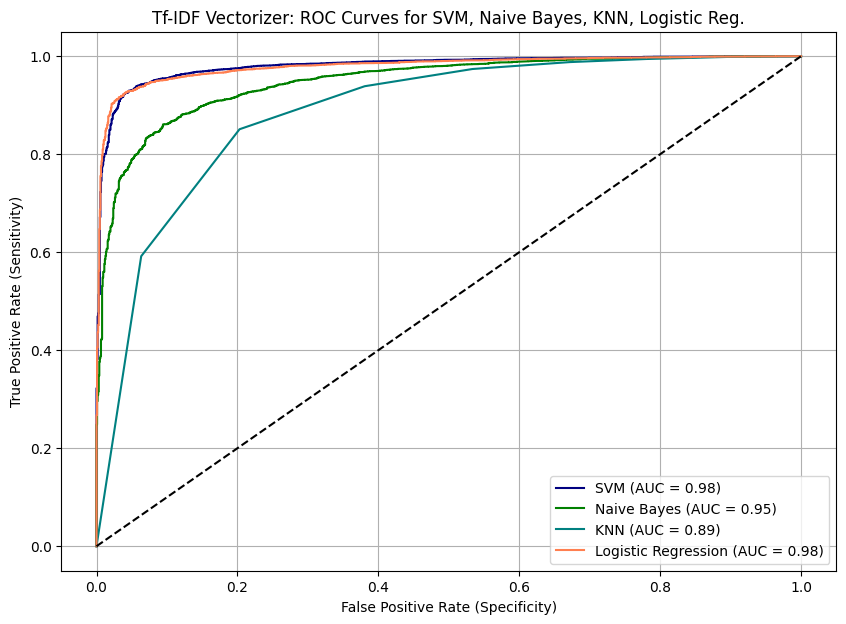

In [ ]:
print("AUC for SVM:", round(roc_auc_svm, 4))
print("AUC for Naive Bayes:", round(roc_auc_nb, 4))
print("AUC for KNN:", round(roc_auc_knn, 4))
print("AUC for Logistic Regression:", round(roc_auc_lr, 4))

plt.figure(figsize=(10, 7))
plt.plot(fpr_svm, tpr_svm, label = f"SVM (AUC = {roc_auc_svm:.2f})", color= 'navy')
plt.plot(fpr_nb, tpr_nb, label = f"Naive Bayes (AUC = {roc_auc_nb:.2f})", color='green')
plt.plot(fpr_knn, tpr_knn, label = f"KNN (AUC = {roc_auc_knn:.2f})", color ='teal')
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='coral')

# line that indicates random guessing
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Tf-IDF Vectorizer: ROC Curves for SVM, Naive Bayes, KNN, Logistic Reg.")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("G-Mean Score for SVM: ", geometric_mean_score(y_test, svm_pred))
print("Cohen-Kappa Score for SVM: ", cohen_kappa_score(y_test, svm_pred))
print("Balanced Accuracy for SVM: ", balanced_accuracy_score(y_test, svm_pred), "\n")

print("G-Mean Score for Naive Bayes: ", geometric_mean_score(y_test, nb_pred))
print("Cohen-Kappa Score for Naive Bayes: ", cohen_kappa_score(y_test, nb_pred))
print("Balanced Accuracy for Naive Bayes: ", balanced_accuracy_score(y_test, nb_pred), "\n")

print("G-Mean Score for K-Nearest Neighbors: ", geometric_mean_score(y_test, knn_pred))
print("Cohen-Kappa Score for K-Nearest Neighbors: ", cohen_kappa_score(y_test, knn_pred))
print("Balanced Accuracy for K-Nearest Neighbors: ", balanced_accuracy_score(y_test, knn_pred))

G-Mean Score for SVM:  0.8983473651613427
Cohen-Kappa Score for SVM:  0.8127873608557786
Balanced Accuracy for SVM:  0.9011363429099596 

G-Mean Score for Naive Bayes:  0.6466246432624427
Cohen-Kappa Score for Naive Bayes:  0.5166342803605568
Balanced Accuracy for Naive Bayes:  0.7054199044520947 

G-Mean Score for K-Nearest Neighbors:  0.5695400017036131
Cohen-Kappa Score for K-Nearest Neighbors:  0.4183649833658638
Balanced Accuracy for K-Nearest Neighbors:  0.6581625588568571
